G05: Jakober, Winkler, Matzinger, Salzmann

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
from torch.utils.data import DataLoader

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


## Loading the Data

In [3]:
transform = ToTensor()

train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                      
    transform = transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = '../data/', 
    train = False, 
    transform = transform,
    download = True
)

In [4]:
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

## Defining the Network

In [5]:
class ParallelCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()

        # First conv branch
        self.conv1a = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.dropout1a = nn.Dropout(dropout)
        self.pool1a = nn.MaxPool2d(kernel_size=2)

        # Second conv branch
        self.conv1b = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.dropout1b = nn.Dropout(dropout)
        self.pool1b = nn.MaxPool2d(kernel_size=2)

        # Output size of each branch
        self.flatten_size = 32 * 16 * 16
        
        # Fc layers after concatenating
        self.fc1 = nn.Linear(self.flatten_size * 2, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First branch
        x1 = F.relu(self.conv1a(x))
        x1 = self.dropout1a(x1)
        x1 = self.pool1a(x1)
        x1 = torch.flatten(x1, 1)

        # Second branch
        x2 = F.relu(self.conv1b(x))
        x2 = self.dropout1b(x2)
        x2 = self.pool1a(x2)
        x2 = torch.flatten(x2, 1)

        # Concat and pass through dense layers
        x_cat = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x_cat))
        return self.fc2(x)

In [6]:
model = ParallelCNN()
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            896
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            2,097,280
├─Linear: 1-8                            1,290
Total params: 2,100,362
Trainable params: 2,100,362
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            896
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            2,097,280
├─Linear: 1-8                            1,290
Total params: 2,100,362
Trainable params: 2,100,362
Non-trainable params: 0

## Training Loop

In [7]:
def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs, save_path="best_model.pth"):
    """
    Trains and evaluates the model for n_epochs.
    Saves best model weights based on validation accuracy.
    """
    total_batches = n_epochs * len(train_loader)
    progress = tqdm(total=total_batches, desc="Training Progress", leave=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(n_epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0
        y_preds, y_trues = [], []

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, 1)
            train_correct += (y_pred == y_train).sum().item()
            train_total += y_train.size(0)

            progress.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        val_loss = 0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)
                loss = criterion(output, y_val)

                val_loss += loss.item()
                _, y_pred = torch.max(output, 1)
                val_correct += (y_pred == y_val).sum().item()
                val_total += y_val.size(0)

                y_preds.append(y_pred.detach().cpu())
                y_trues.append(y_val.detach().cpu())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)

        progress.set_postfix({
            'Epoch': f'{epoch + 1}/{n_epochs}',
            'Train Loss': f'{avg_train_loss:.4f}',
            'Val Loss': f'{avg_val_loss:.4f}',
            'Train Acc': f'{train_acc:.4f}',
            'Val Acc': f'{val_acc:.4f}'
        })
    
    y_preds = torch.cat(y_preds, dim=0).numpy()
    y_trues = torch.cat(y_trues, dim=0).numpy()

    progress.close()

    model.load_state_dict(best_model_wts)

    return train_losses, val_losses, train_accs, val_accs, y_preds, y_trues

In [8]:
def plot_cm(y_trues, y_preds):
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [9]:
def eval(model, test_loader, criterion):
    y_preds = []
    y_trues = []

    model.to(device)
    test_loss = 0
    test_corr = 0

    model.eval()
    for X_test, y_test in tqdm(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)

        output = model(X_test)
        loss = criterion(output, y_test)

        test_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        test_corr += torch.sum(y_pred == y_test).item()

        y_preds.append(y_pred.cpu())
        y_trues.append(y_test.cpu())

    y_preds = torch.cat(y_preds).numpy()
    y_trues = torch.cat(y_trues).numpy()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_corr / len(test_loader.dataset)

    print()
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}')
    plot_cm(y_trues, y_preds)

In [10]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_preds, y_trues):
    
    _, ax = plt.subplots(1, 3, figsize=(14,4), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[2])
    
    plt.show()

In [11]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [22]:
configs = {
    "config1": [0.25, 0.001, 0],
    "config2": [0.50, 0.001, 0],
    "config3": [0.50, 0.001, 1e-4]
}

Training Progress: 100%|██████████| 4695/4695 [02:04<00:00, 37.64it/s, Epoch=15/15, Train Loss=0.6478, Val Loss=1.0059, Train Acc=0.7731, Val Acc=0.6536]


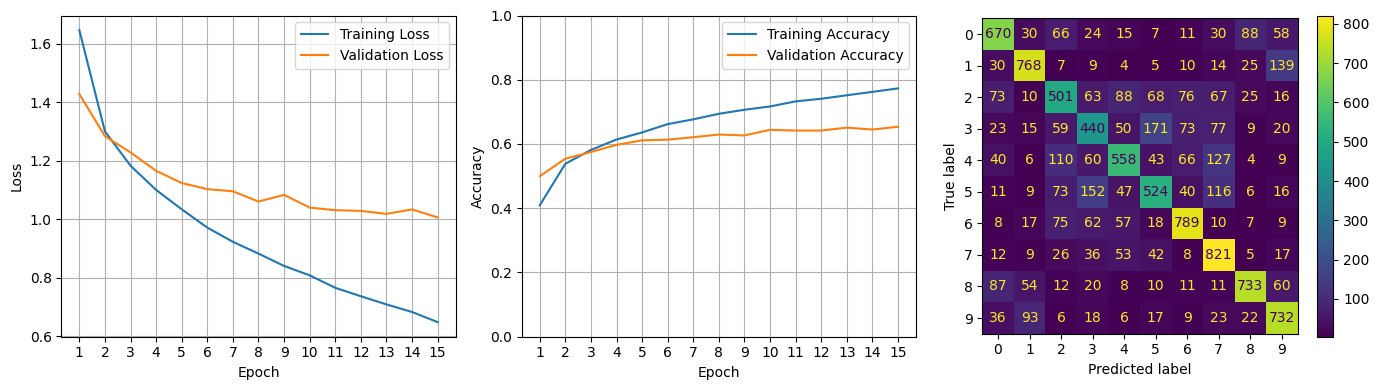

Training Progress: 100%|██████████| 4695/4695 [02:05<00:00, 37.39it/s, Epoch=15/15, Train Loss=0.7298, Val Loss=1.0338, Train Acc=0.7422, Val Acc=0.6427]


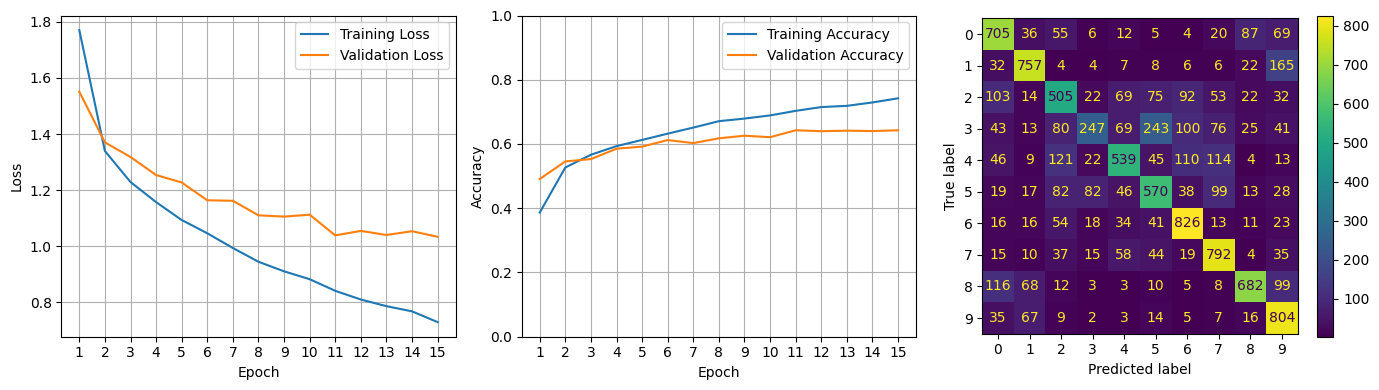

Training Progress: 100%|██████████| 4695/4695 [02:05<00:00, 37.54it/s, Epoch=15/15, Train Loss=0.7092, Val Loss=1.0292, Train Acc=0.7514, Val Acc=0.6429]


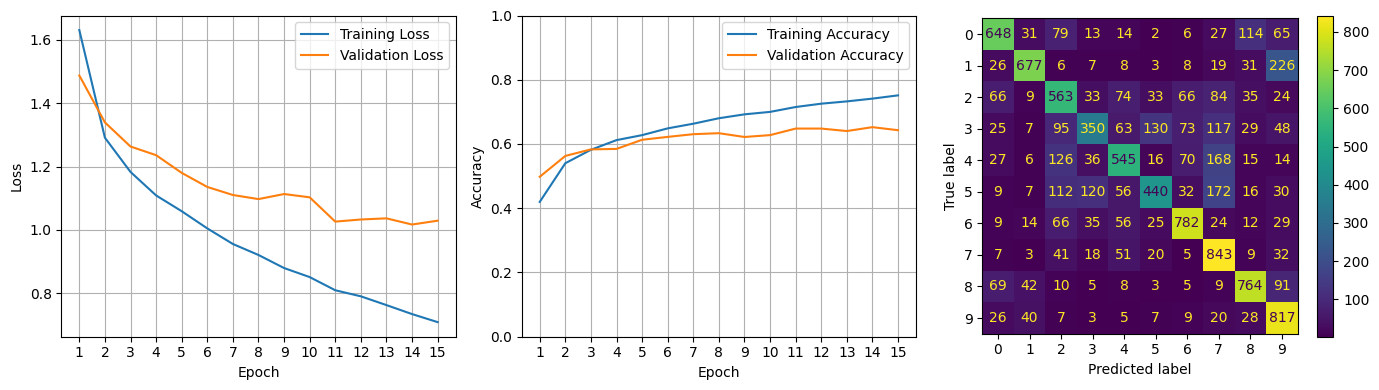

In [23]:
n_epochs = 15

for values in configs.values():
    model = ParallelCNN(dropout=values[0]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=values[1], weight_decay=values[2])

    train_losses, val_losses, train_acc, val_acc, y_preds, y_trues = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_preds, y_trues)
    eval(model, test_loader, criterion)